#Dynamic Models for Building Energy Management

1) Modèle

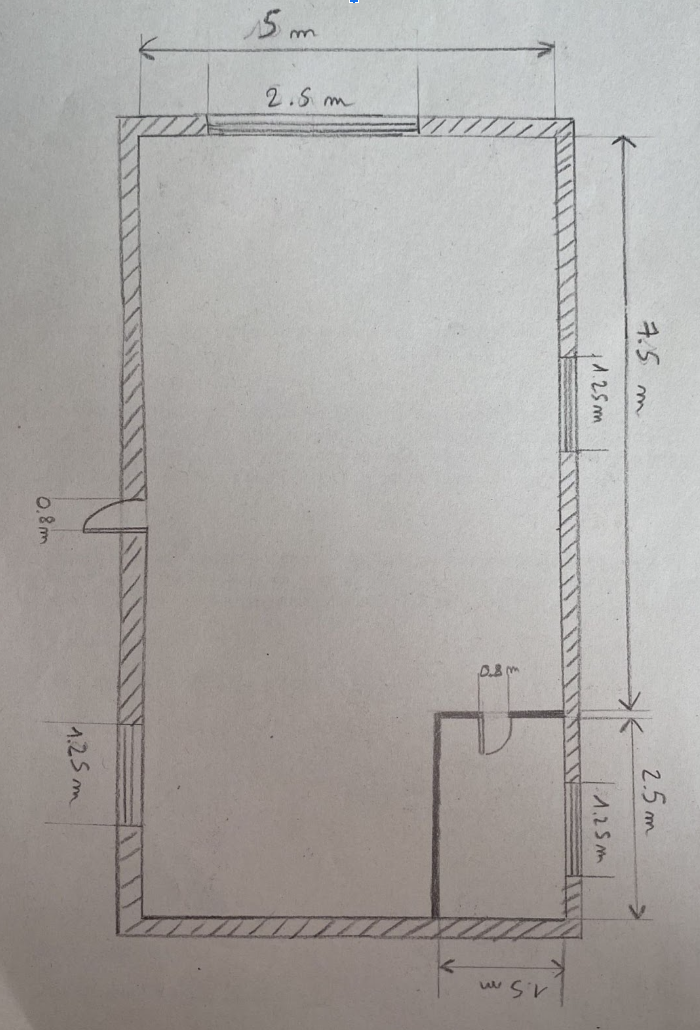

Notre bâtiment est composé d'une grande pièce de 10m x 5m, avec une épaisseur de mur de 28cm. Elle est composé d'une porte de 0.8m x 2m, d'une fenêtre de 1.25m x 1m, et d'une grande fenêtre de 2.5m x 1.5m. Enfin, une petite pièce est à l'intérieur de cette dernière, séparée par une cloison de 7cm d'épaisseur. Elle comporte une porte de 0.8m x 2m.

2. Conditions aux limites et hypothèses

Pour faciliter les calculs et le dimensionnement, plusieurs hypothèses doivent être prises en compte : 

    - Les transferts thermiques au sol et au plafond seront négligés. 
    - La température est considérée comme uniforme sur toute la surface des murs et des vitrages.
    - Les transferts thermiques seront unidirectionnels dans les murs, portes et les vitrages.
    - Les transferts thermiques seront supposés linéaire.
    - On suppose les transferts thermiques dus aux appareils électroniques ainsi que les lumières comme négligeables.
    
Pour les conditions aux limites, nous avons : 

    - Température extérieur de 5°C.
    - Température intérieur de 20°C dans les 2 pièces.

3. Type de portes, fenêtres et murs

Pour les murs extérieurs, nous allons considéré un mur constitué de béton, de laine de verre et de placo. Voici plus précisément une représentation des proportions des éléments de nos murs : 

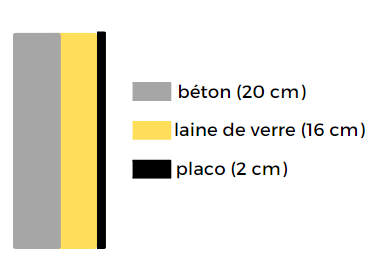![cube](./figures/photo2.jpg)

Pour la cloison intérieure, nous avons choisi une isolation thermique et acoustique avec de la laine de verre de 5cm d'épaisseur.Une ligne de montant métallique de part et d'autre de l'isolant va permettre ensuite de positionner du placo de 1cm d'épaisseur.

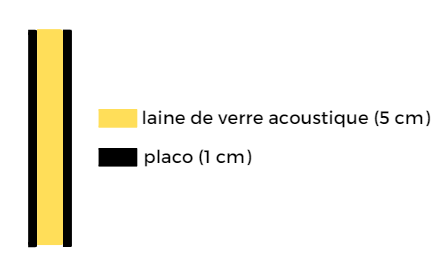

Pour les fenêtres, nous allons tout simplement utiliser un double vitrage séparé par de l'argon. Pour les dimensions, nous allons prendre des vitres en verre de 4mm d'épaisseur, et un espace entre d'environ 16mm.

Pour les portes, nous allons privilégier les portes postformées. L’âme de la porte postformée sera composée de bois aggloméré. Le parement qui recouvre les 2 côtés sera du bois massif. 

4) Schéma électrique équivalent du bâtiment

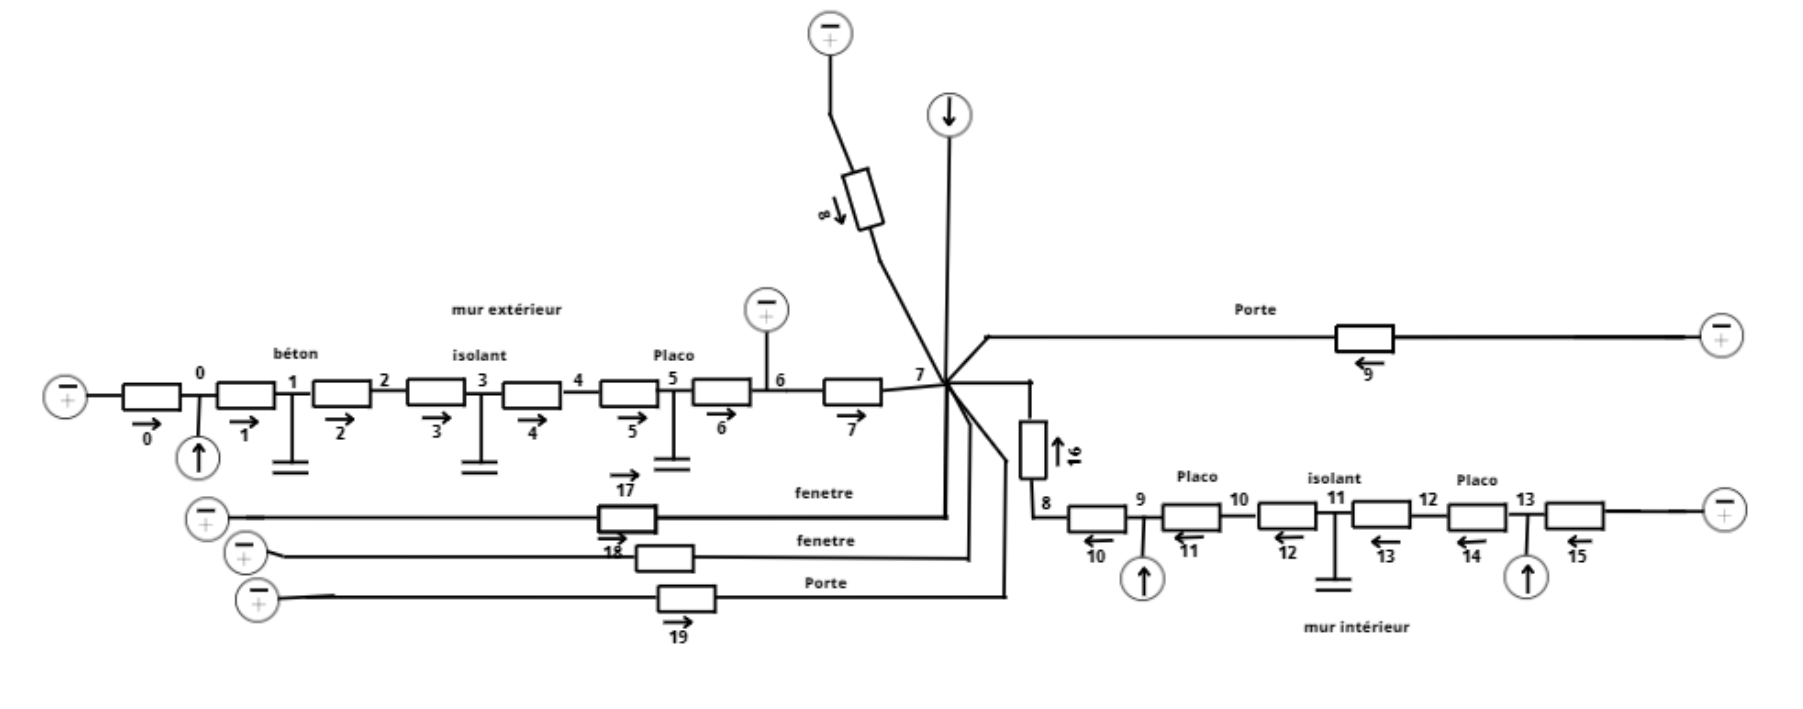

6. Calculs des résistances thermiques de convection, conduction et autre

Tout d'abord, voici un tableau récapitulatif des différentes valeurs des matériaux que l'on devra prendre en considération : 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import tuto

concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': 2*10*3 + 2*5*3 - 1.25*1 - 2.5*1.5 - 0.8*2}

external_insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.16,
              'Surface': 2*10*3 + 2*5*3 - 1.25*1 - 2.5*1.5 - 0.8*2}
              
internal_insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.05,
              'Surface': 2.5*3 + 1.5*3 - 0.8*2}


placo = {'Conductivity': 0.035,
              'Density': 850,
              'Specific heat': 1200,
              'Width': 0.02,
              'Surface': 2*10*3 + 2*5*3 - 1.25*1 - 2.5*1.5 - 0.8*2 + 2.5*3 + 1.5*3 - 0.8*2}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.008,
         'Surface': 2.5*1.5 + 1.25*1}

door = {'Conductivity': 0.16,
         'Density': 800,
         'Specific heat': 2385,
         'Width': 0.07,
         'Surface': 0.8*2 * 2}



wall = pd.DataFrame.from_dict({'external_insulation': external_insulation,
                               'internal_insulation': internal_insulation, 
                               'concrete': concrete,
                               'door' : door,
                               'Glass': glass,
                               'placo': placo},
                              orient='index')
wall

,Conductivity,Density,Specific heat,Width,Surface
external_insulation,0.027,55.0,1210,0.160,83.4
internal_insulation,0.027,55.0,1210,0.050,10.4
concrete,1.400,2300.0,880,0.200,83.4
door,0.160,800.0,2385,0.070,3.2
Glass,1.400,2500.0,1210,0.008,5.0
placo,0.035,850.0,1200,0.020,93.8


Nous mettons également en évidence les radiations en fonction des matériaux : 

In [3]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

On rappelle également la constance de Boltzmann, qui nous sera utile pour la suite : 

In [4]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

 Pour les coefficients de convection, on prendra les valeurs conventionnels pour ces coefficients etxtérieurs et intérieurs : 

In [5]:
h_in = 8
h_out = 25

Nous allons maintenant calculer les conductances thermiques de notre pièce : on rappelle la formule de la conductance de conduction: 

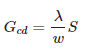

In [6]:
Gcd = wall['Conductivity'] / wall['Width'] * wall['Surface']
G_cd = pd.DataFrame(Gcd, columns={'Conductance'})
G_cd


,Conductance
external_insulation,14.073750
internal_insulation,5.616000
concrete,583.800000
door,7.314286
Glass,875.000000
placo,164.150000


Pour la conductance de convection, on utilise la formule suivante : 

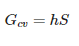

In [7]:
Gp_in = h_in * wall['Surface'][2]       # placo_in
Gc_in = h_in * 2.5*3 + 1.5*3 - 0.8*2       # cloison_in
Gg_in = h_in * wall['Surface'][4]       # glass_in
Gd_in = h_in * wall['Surface'][3]       #door_in
Gc_out = h_out * wall['Surface'][2]     # concrete_out
Gg_out = h_out * wall['Surface'][4]     # glass_out
Gd_out = h_out * wall['Surface'][3] /2  #door_out


convection = pd.DataFrame.from_dict({'Gp_in': Gp_in,
                               'Gc_in': Gc_in,
                               'Gg_in': Gg_in, 
                               'Gd_in': Gd_in,
                               'Gc_out' : Gc_out,
                               'Gg_out': Gg_out,
                               'Gd_out': Gd_out},
                              orient='index',columns={'Convection'})
convection

,Convection
Gp_in,667.2
Gc_in,62.9
Gg_in,40.0
Gd_in,25.6
Gc_out,2085.0
Gg_out,125.0
Gd_out,40.0


Calculons maintenant les rayonnement à ondes longues. On trouve d'abord l'émissivité de chaque matériaux, et le facteur de forme entre vitre et mur : 

In [8]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange
ε_wLW = 0.91
ε_gLW = 0.92
Fwg = wall['Surface'][4] / wall['Surface'][2]

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['concrete']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['concrete']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
print ('GLW1 =',GLW1,'\nGLW12 =',GLW12,'\nGLW2 =',GLW2 )

GLW1 = 4810.728469070163 
GLW12 = 28.524360438 
GLW2 = 328.0301450370002


Et donc la conductance équivalente entre les murs et les vitres est : 

In [9]:
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
print ('GLW =',GLW)

GLW = 26.100036512489464


On va aussi calculer l'advection du système de ventilation en utilisant la formule ci-contre : 

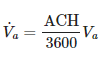

In [10]:
# ventilation flow rate
Va = 5 * 10 * 3     
ACH = 1  # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration
print ("Va_dot = ",Va_dot)

Va_dot =  0.041666666666666664


Et donc la conductance de l'advection est égale à : 

In [11]:
p_air = 1.2                
Cs_air = 1000
Gv = p_air * Cs_air * Va_dot 
print ("Gv = ", Gv)

Gv =  50.0


6. Calculs des capacités thermiques

Calculons maintenant les capacités thermiques de chaque matériaux de notre bâtiment : 

Pour les murs, utilisons la formule suivante : 

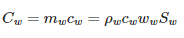

Et pour l'air : 

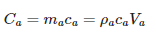

In [12]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

C['Air'] = p_air * Cs_air * Va
capacity = pd.DataFrame(C, columns={'Capacity'})
capacity

,Capacity
external_insulation,888043.2
internal_insulation,34606.0
concrete,33760320.0
door,427392.0
Glass,121000.0
placo,1913520.0
Air,180000.0


7. Définition des matrices

On définit d'abord la valeur du gain du controller (On le prend pas trop grand pour une question de stabilité) : 

In [55]:
Kp = 1e-3

On peut alors définir les matrices souhaitées : 

In [35]:
A = np.zeros([20, 14])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 5], A[6, 6] = -1, 1    # branch 6: node 5 -> node 6
A[7, 6], A[7, 7] = -1, 1    # branch 7: node 6 -> node 7
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 7] = 1                 # branch 9: -> node 7
A[17, 7] = 1                # branch 17: -> node 7
A[18, 7] = 1                # branch 18: -> node 7
A[19, 7] = 1                # branch 19: -> node 7
A[15, 13] = 1                   # branch 15: -> node 13
A[14, 13], A[14, 12] = -1, 1    # branch 14: node 13 -> node 12
A[13, 12], A[13, 11] = -1, 1    # branch 13: node 12 -> node 11
A[12, 11], A[12, 10] = -1, 1    # branch 12: node 11 -> node 10
A[11, 10], A[11, 9] = -1, 1     # branch 11: node 10 -> node 9
A[10, 9], A[10, 8] = -1, 1      # branch 10: node 9 -> node 8
A[16, 8], A[16, 7] = -1, 1      # branch 16: node 8 -> node 7

# np.set_printoptions(suppress=False)
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
G = np.diag((np.hstack((
    convection['Convection'][4], G_cd['Conductance'][2],G_cd['Conductance'][2], G_cd['Conductance'][0], 
     G_cd['Conductance'][0], G_cd['Conductance'][5], G_cd['Conductance'][5], GLW, Kp, G_cd['Conductance'][3], 
     G_cd['Conductance'][5], G_cd['Conductance'][5], G_cd['Conductance'][1], 
     G_cd['Conductance'][1], G_cd['Conductance'][5], convection['Convection'][6], 
     GLW, G_cd['Conductance'][4],G_cd['Conductance'][4],G_cd['Conductance'][3]))))


#np.set_printoptions(precision=3, threshold=16, suppress=True)
#pd.set_option("display.precision", 1)
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2085.0,0.0,0.0,0.00000,0.00000,0.00,0.00,0.000000,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
1,0.0,583.8,0.0,0.00000,0.00000,0.00,0.00,0.000000,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,583.8,0.00000,0.00000,0.00,0.00,0.000000,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.0,14.07375,0.00000,0.00,0.00,0.000000,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.00000,14.07375,0.00,0.00,0.000000,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.00000,0.00000,164.15,0.00,0.000000,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.00000,0.00000,0.00,164.15,0.000000,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
7,0.0,0.0,0.0,0.00000,0.00000,0.00,0.00,26.100037,0.000,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
8,0.0,0.0,0.0,0.00000,0.00000,0.00,0.00,0.000000,0.001,0.000000,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000
9,0.0,0.0,0.0,0.00000,0.00000,0.00,0.00,0.000000,0.000,7.314286,0.00,0.00,0.000,0.000,0.00,0.0,0.000000,0.0,0.0,0.000000


In [37]:
C = np.diag([0, capacity['Capacity'][2], 0, capacity['Capacity'][0], 0, capacity['Capacity'][5],0, 0, 0, 0, 0, capacity['Capacity'][1], 0, 0])
pd.DataFrame(C)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,33760320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,888043.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1913520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
b = np.zeros(20)        # branches
b[[0, 9, 15, 17, 18, 19]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]


In [39]:
f = np.zeros(14)         # nodes
f[[0, 7]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [40]:
y = np.zeros(14)         # nodes
y[[7]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


8. State space representation

On va maintenant transformer notre DAE en state space representation. 

In [41]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')
print(np.shape(Bs))
print(np.shape(As))
print(np.shape(Cs))
print(np.shape(Ds))


As = 
 [[-1.39168174e-05  4.07059488e-07  0.00000000e+00  0.00000000e+00]
 [ 1.54749888e-05 -3.00715667e-05  1.45965779e-05  0.00000000e+00]
 [ 0.00000000e+00  6.77410831e-06 -1.83947624e-05  2.87408668e-08]
 [ 0.00000000e+00  0.00000000e+00  1.58921064e-06 -2.64279884e-04]] 

Bs = 
 [[1.35097579e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.47950019e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.80477981e-08 0.00000000e+00 5.74790553e-06
  5.74790553e-06 4.80477981e-08 0.00000000e+00 6.56903489e-09]
 [0.00000000e+00 5.16174008e-07 1.38159590e-04 6.17493320e-05
  6.17493320e-05 5.16174008e-07 0.00000000e+00 7.05706652e-08]] 

Cs = 
 [[0.         0.         0.01256998 0.00244217]] 

Ds = 
 [[0.         0.00408272 0.         0.48841093 0.48841093 0.00408272
  0.         0.00055818]] 

(4, 8)
(4, 4)
(1, 4)
(1, 8)


9. Steady State

En steady state, de nouvelles conditions sont prises en compte : 

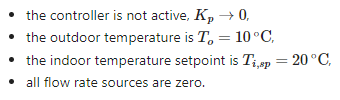

On redéfinit alors les matrices b et f suivantes : 

In [42]:
b = np.zeros(20)        # temperature sources
b[[0, 17, 18]] = 10      # outdoor temperature
b[[8,9,15,19]] = 20            # indoor set-point temperature

fq = np.zeros(14)# flow-rate sources

print(b)
print(f)

[10.  0.  0.  0.  0.  0.  0.  0. 20. 20.  0.  0.  0.  0.  0. 20.  0. 10.
 10. 20.]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Et on définit la température θ comme suivant : 

In [43]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10.00071279 10.00154556 10.00237833 10.03692279 10.07146726 10.074429
 10.07739074 10.09601793 10.96293361 11.10077419 11.23861477 15.26755546
 19.29649615 19.43433673] °C


On définit également u : 

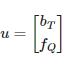

In [44]:
bT = np.array([10, 10, 10, 20, 20, 20, 20])     # [To, To, To, Tisp, Tisp, Tisp, Tisp]
fQ = np.array([0, 0, 0, 0, 0, 0, 0])
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 20 20 20 20  0  0  0  0  0  0  0]


9. Dynamic Simulation

La condition se stabilité à respecter de la méthode d'Euler implicite est : 

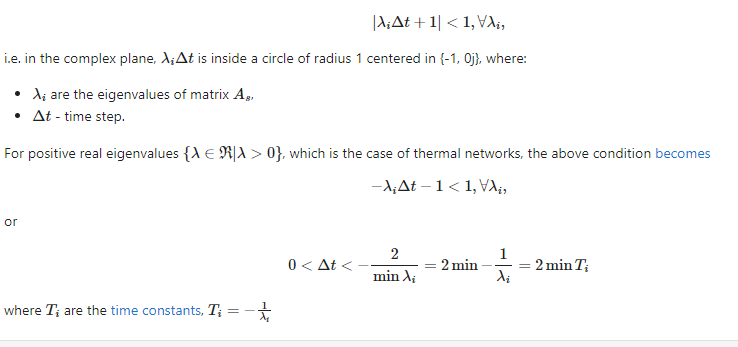

In [45]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [27793.31016538 68778.27543505 84291.4150395   3783.86460035] s 

2 x Time constants: 
 [ 55586.62033077 137556.5508701  168582.830079     7567.7292007 ] s 

Maximum time step: 7567.73 s = 126.13 min


Choisissons maintenant un temps de réponse plus faible : 

In [46]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 7560.0 s = 126 min


Comme on néglige la capacité de l'air, le temps de réponse est bien plus grand que celui attendu, mais cela reste cohérent.

In [47]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [ 15132 111172 275112 337164] s 

Settling time: 337166 s = 5619.4 min = 93.66 h = 3.90 days


Obtenons maintenant le temps de réponse dynamique du système : 

In [48]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 338400.0 s
Number of time steps = 44


On cherche maintenant le vecteur d'entrée u définit comme : 

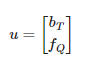

In [49]:
u = np.zeros([8, n])
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3:7, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
4,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
5,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
6,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En intégrant à l'aide de la méthode d'Euler, on obtient : 

In [73]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
        
#print(θ_imp)


On obtient alors la sortie suivant :

$$ y = C_s \theta_s + D_s u$$



In [70]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

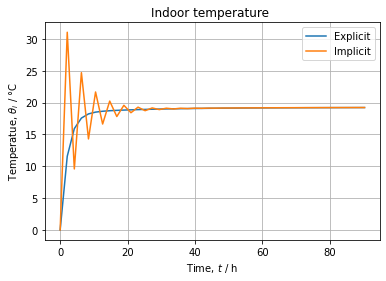

In [72]:
fig, ax = plt.subplots()
ax.plot(t/3600, y_imp.T)
ax.plot(t/3600, y_exp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Indoor temperature ')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

##### Irradiation solaires des murs
Pour la surface orientée définit par For `slope`, `azimuth` et `latitude`, et `albedo` de la surface en face du mur, on peut calculer (en utilisant les données météos) :
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,


In [77]:
filename = './FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

Pour l'irrandiance totale [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, en W/m², est la somme des composantes de diffusion, réflexion et autre.

In [79]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)
print(rad_surf)

                              direct  diffuse  reflected        Φtot
2000-01-03 12:00:00+01:00   5.423683     66.5  27.025936  197.899238
2000-01-03 13:00:00+01:00  62.074669     75.0  34.289730  342.728798
2000-01-03 14:00:00+01:00  66.175859     67.5  30.353167  328.058052
2000-01-03 15:00:00+01:00  38.420856     42.0  17.456968  195.755648
2000-01-03 16:00:00+01:00   0.000000      9.5   3.800000   26.600000
...                              ...      ...        ...         ...
2000-03-04 14:00:00+01:00   0.000000     65.5  26.200000  183.400000
2000-03-04 15:00:00+01:00   0.000000     50.5  20.200000  141.400000
2000-03-04 16:00:00+01:00   0.000000     41.0  16.400000  114.800000
2000-03-04 17:00:00+01:00   0.000000     17.0   6.800000   47.600000
2000-03-04 18:00:00+01:00   0.000000      1.0   0.400000    2.800000

[1447 rows x 4 columns]


En utilisant maintenant la météo, on peut avoir : 

In [53]:
weather_file = './FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-03-04 18:00:00'

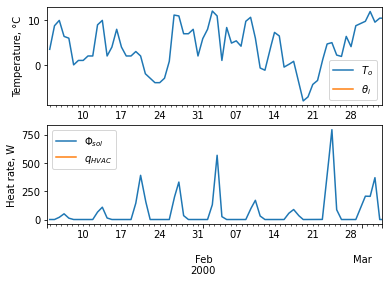

In [54]:
Tisp = 20
y, q_HVAC, data = tuto.P_control(
    weather_file, start_date, end_date, dt,
    As, Bs, Cs, Ds, Kp, Tisp)
tuto.plot_results(y, q_HVAC, data)

On décide de prendre maintenant un gain Kp parfait : 

In [56]:
Kp = 1e3    # P-controler gain, Kp -> ∞

In [57]:
TCa = tuto.thermal_circuit(Kp)

Le circuit thermique tCa est alors converti en représentation d'état : 

In [58]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])

On a alors :

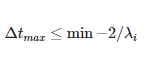

In [59]:
dtmax = min(-2. / np.linalg.eig(As)[0])
dtmax = -2. / min(np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 58.92 s


On choisit alors un pas de temps inférieur à celui maximum : 

In [60]:
dt = 50   # [s] simulation time step
print(f'dt = {dt} s')

dt = 50 s


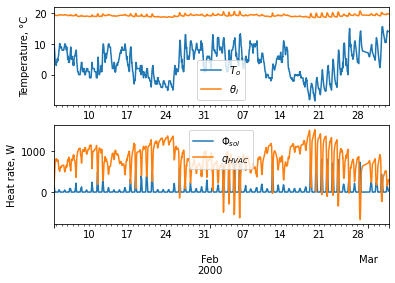

In [62]:
y, q_HVAC, data = tuto.P_control(
    weather_file, start_date, end_date, dt,
    As, Bs, Cs, Ds, Kp, Tisp)
tuto.plot_results(y, q_HVAC, data)